In [2]:
import numpy, scipy, matplotlib.pyplot as plt, pandas, librosa,sklearn
import numpy as np
import pandas as pd
import math
import seaborn as sns
from time import time
from numpy import unique
from numpy import where
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from pyclustertend import hopkins
from scipy.cluster.hierarchy import dendrogram

## Load Data

In [32]:
data_cluster = pd.read_csv('music_dataset3.csv')
dataset_cluster = np.array(data_cluster)
cluster_dataset = dataset_cluster[:,:-1]

## Check the Principle Components

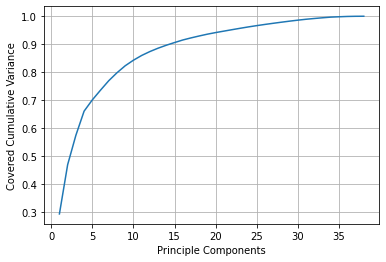

The first 14 Principle Components have been chosen, which cover % 90.602 of variance.


In [33]:
pca = PCA()
pca.fit(cluster_dataset)
evr = pca.explained_variance_ratio_
pca_data_size = cluster_dataset.shape[1]
pc_num = np.min([i for i,v in enumerate(evr.cumsum()) if v > 0.9])
pc_percent = evr.cumsum()[pc_num]
plt.plot(np.linspace(1,pca_data_size,pca_data_size), evr.cumsum())
plt.xlabel("Principle Components")
plt.ylabel("Covered Cumulative Variance")
plt.grid()
plt.savefig("pca_cluster")
plt.show()
print("The first",pc_num,"Principle Components have been chosen, which cover %",round(pc_percent*100,3),"of variance.")

In [34]:
pca = PCA(n_components = pc_num, whiten=True)
data_pca = pca.fit_transform(cluster_dataset)

In [35]:
n_components = 14
lda = LinearDiscriminantAnalysis()
data_lda = lda.fit_transform(cluster_dataset[:,:-1],dataset_cluster[:,-1])
# data_lda_2 = np.vstack((data_lda.T,dataset_cluster[:,-1])).T

## K-Means clustering / PCA / LDA

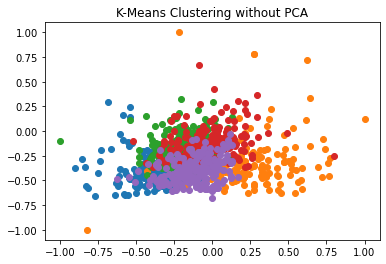

In [36]:
model = KMeans(n_clusters= 5, random_state= 6)
y_pred = model.fit_predict(cluster_dataset)
clusters = np.unique(y_pred)

for cluster in clusters:
    row_ix = np.where(y_pred == cluster)
    plt.scatter(cluster_dataset[row_ix, 0], cluster_dataset[row_ix, 1])
    
plt.title("K-Means Clustering without PCA")
plt.savefig("kmeans")
plt.show()

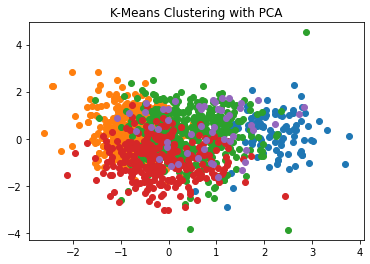

In [37]:
model = KMeans(n_clusters= 5, random_state= 6)
y_pred = model.fit_predict(data_pca)
clusters = np.unique(y_pred)

for cluster in clusters:
    row_ix = np.where(y_pred == cluster)
    plt.scatter(data_pca[row_ix, 0], data_pca[row_ix, 1])
    
plt.title("K-Means Clustering with PCA")  
plt.savefig("kmeans_pca")
plt.show()

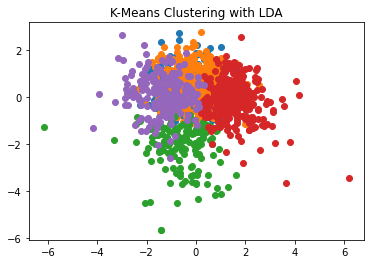

In [38]:
model = KMeans(n_clusters= 5, random_state= 6)
y_pred = model.fit_predict(data_lda)
clusters = np.unique(y_pred)

for cluster in clusters:
    row_ix = np.where(y_pred == cluster)
    plt.scatter(data_lda[row_ix, 0], data_lda[row_ix, 1])
    
plt.title("K-Means Clustering with LDA") 
plt.savefig("kmeans_lda")
plt.show()

In [16]:
X = cluster_dataset
# X = data_pca
# X = data_lda
y = dataset_cluster[:,-1]

In [17]:
print("The hopkins score of the dataset is: %.3f" %hopkins(X, X.shape[0]))

The hopkins score of the dataset is: 0.155


The number of optimal clusters using the empirical method is: 26


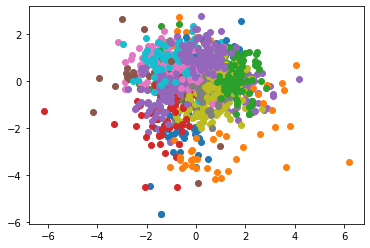

In [43]:
n_cluster_emp = math.sqrt(X.shape[0]/2)
print("The number of optimal clusters using the empirical method is: %d" %n_cluster_emp)

kmeans = KMeans(n_clusters= int(n_cluster_emp), random_state= 6)
y_pred_emp = kmeans.fit_predict(X)
clusters = unique(y_pred_emp)

for cluster in clusters:
    row_ix = where(y_pred_emp == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

plt.savefig("26clusters")
plt.show()

## Check the number of appropriates clusters in case it is unknown

Optimal number of clusters 5


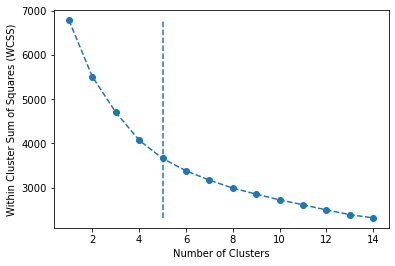

In [42]:
# X = cluster_dataset
# X = data_pca
X = data_lda
y = dataset_cluster[:,-1]

# get within cluster sum of squares for each value of k
wcss = []
max_clusters = 15
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(X)
    wcss.append(kmeans_pca.inertia_)
      
# programmatically locate the elbow
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)
    
# visualize the curve in order to locate the elbow
plt.plot(range(1, max_clusters), wcss, marker='o', linestyle='--')
plt.vlines(n_clusters, ymin=min(wcss), ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.savefig("knee")
plt.show()

## Work a little with dataset and distributions

In [23]:
dialect = {'Bandari':1,'Gilaki':2,'Kurdish':3,'Lori':4,'Turkish':5}
data_cluster_2 = data_cluster
data_cluster_2.Dialect = [dialect[item] for item in data_cluster_2.Dialect]

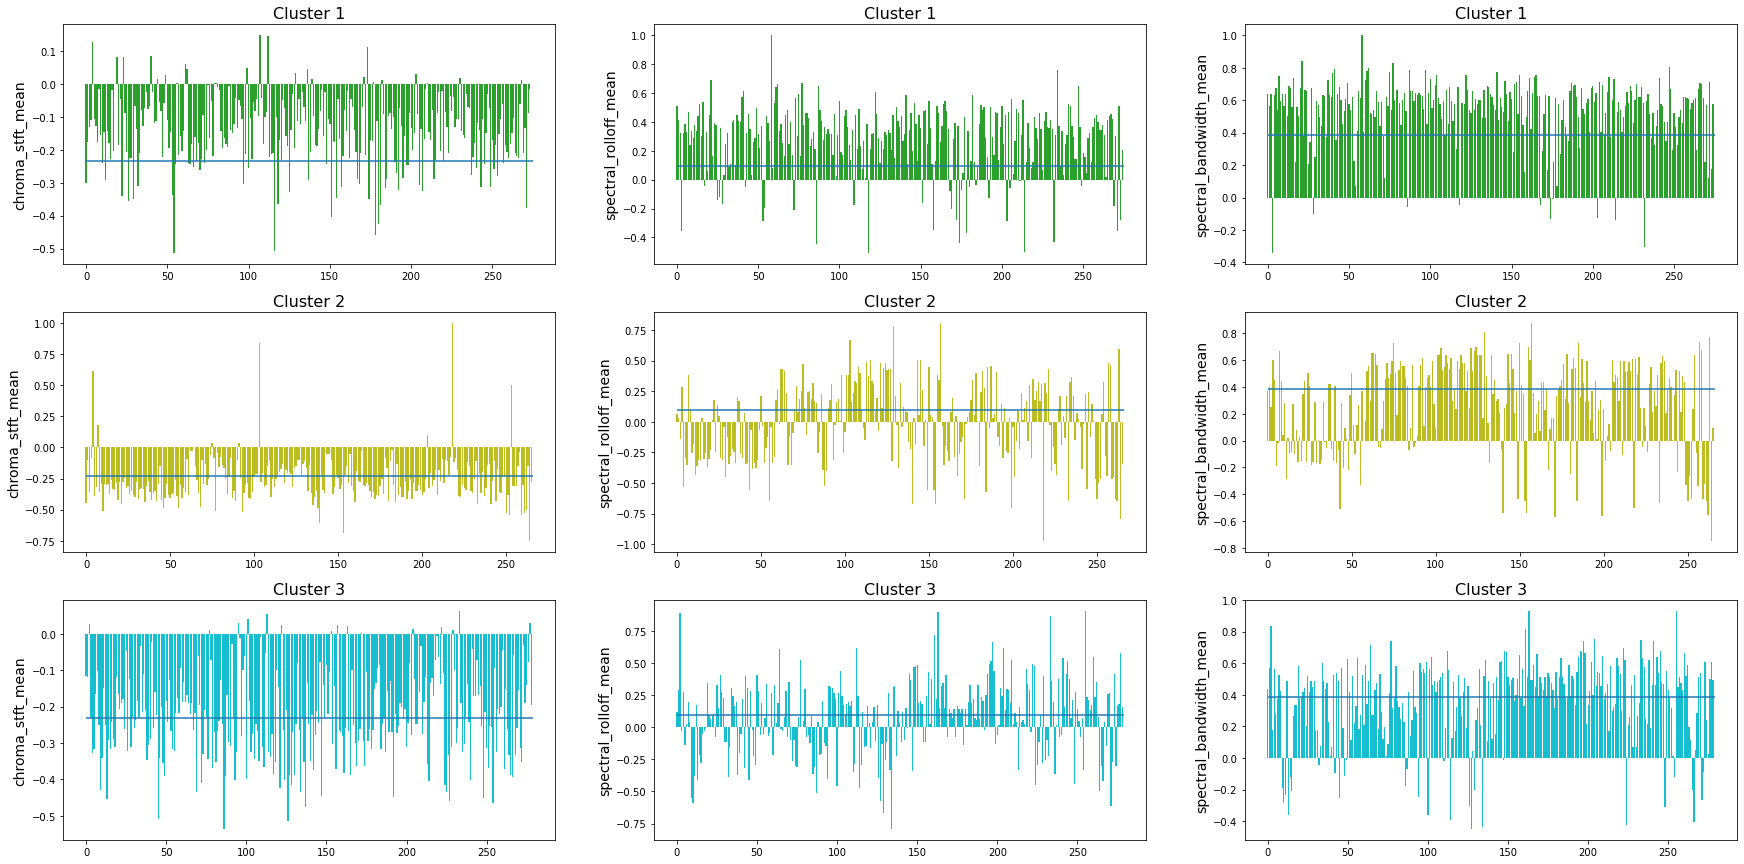

In [109]:
# clusters = [1,2,3,4,5]
# features = ["chroma_stft_mean", "spectral_rolloff_mean", "spectral_bandwidth_mean","spectral_centroid_mean","spectral_contrast_mean"]
# colors = ['tab:green', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']
clusters = [1,2,3]
features = ["chroma_stft_mean", "spectral_rolloff_mean", "spectral_bandwidth_mean"]
colors = ['tab:green', 'tab:olive', 'tab:cyan']
dim = len(clusters)

fig, axes = plt.subplots(dim,dim, figsize=(30, 15))
i = 0
test_cluster = data_cluster.loc[data_cluster_2['Dialect'] == clusters[0]]
for ax in (axes.flatten()):
    if i % dim == 0 and i != 0:
        test_cluster = data_cluster_2.loc[data_cluster_2['Dialect'] == clusters[i // dim]]
    col = features[i % dim]
    y = test_cluster[col]
    x = [i for i in range(len(y))]
    ax.bar(x, y, color=colors[i//dim])
    ax.set_ylabel(col, fontsize=14)
    ax.set_title("Cluster " + str(clusters[i // dim]), fontsize=16)
    ax.hlines(np.mean(data_cluster_2[col]), 0, len(y))
#     plt.subplots_adjust(wspace=.5, hspace=.5)
    i += 1 
    
plt.savefig("3features")    

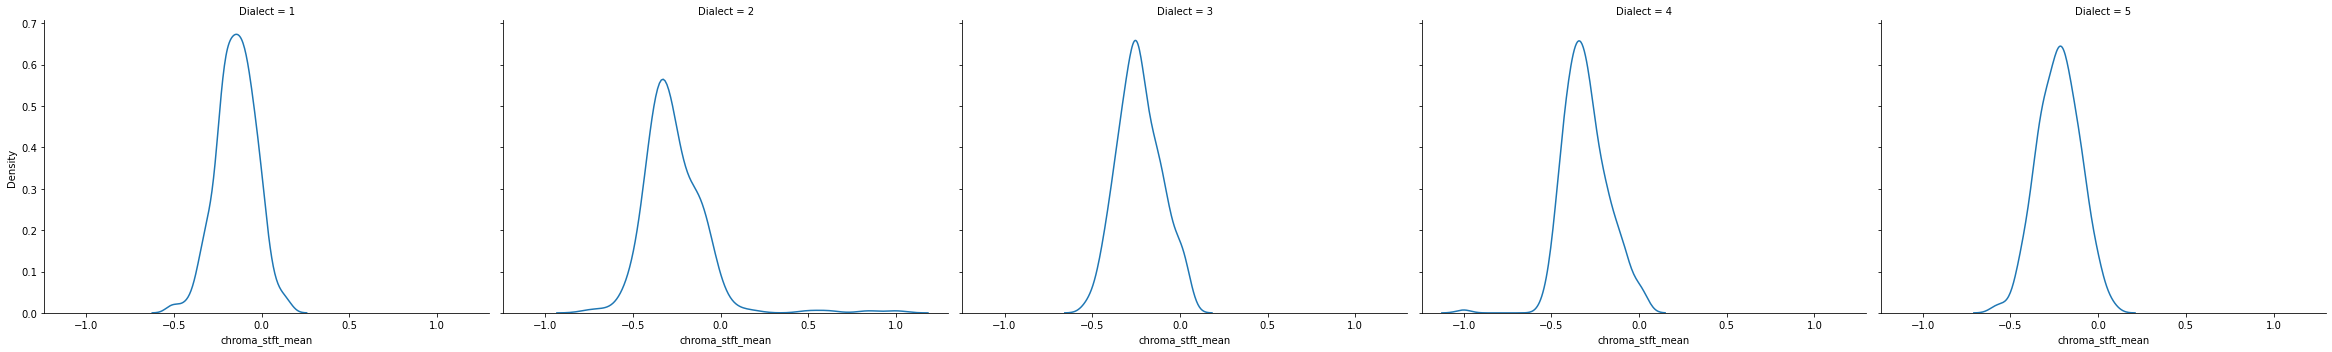

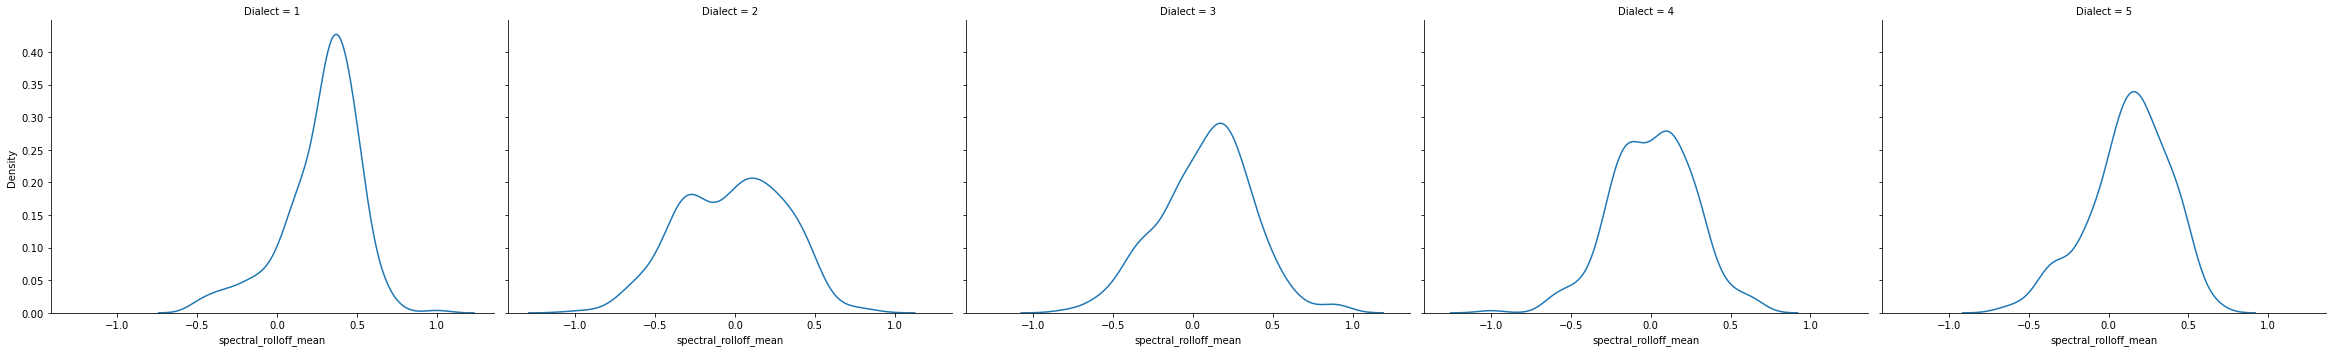

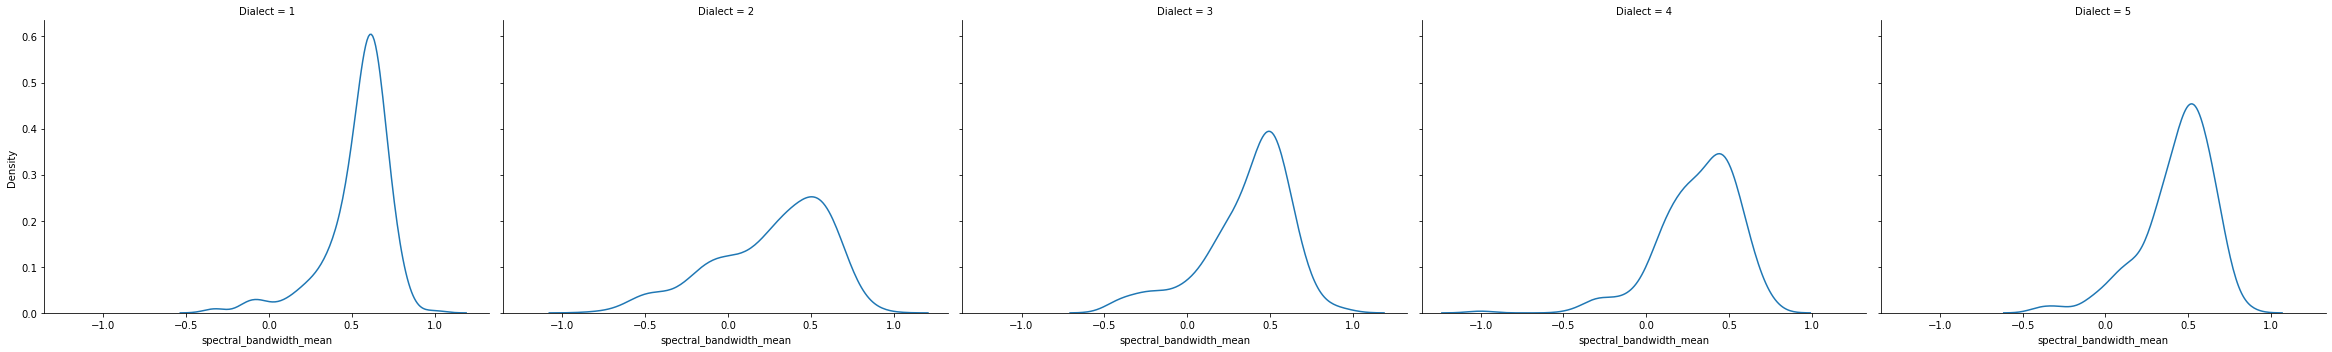

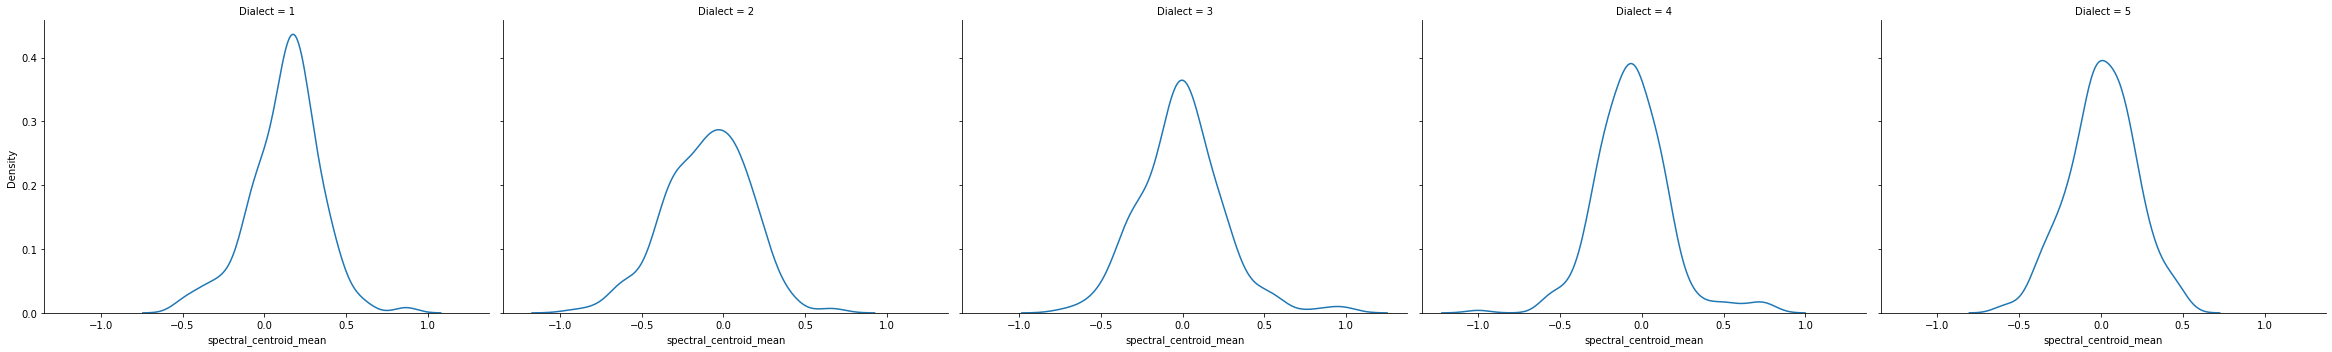

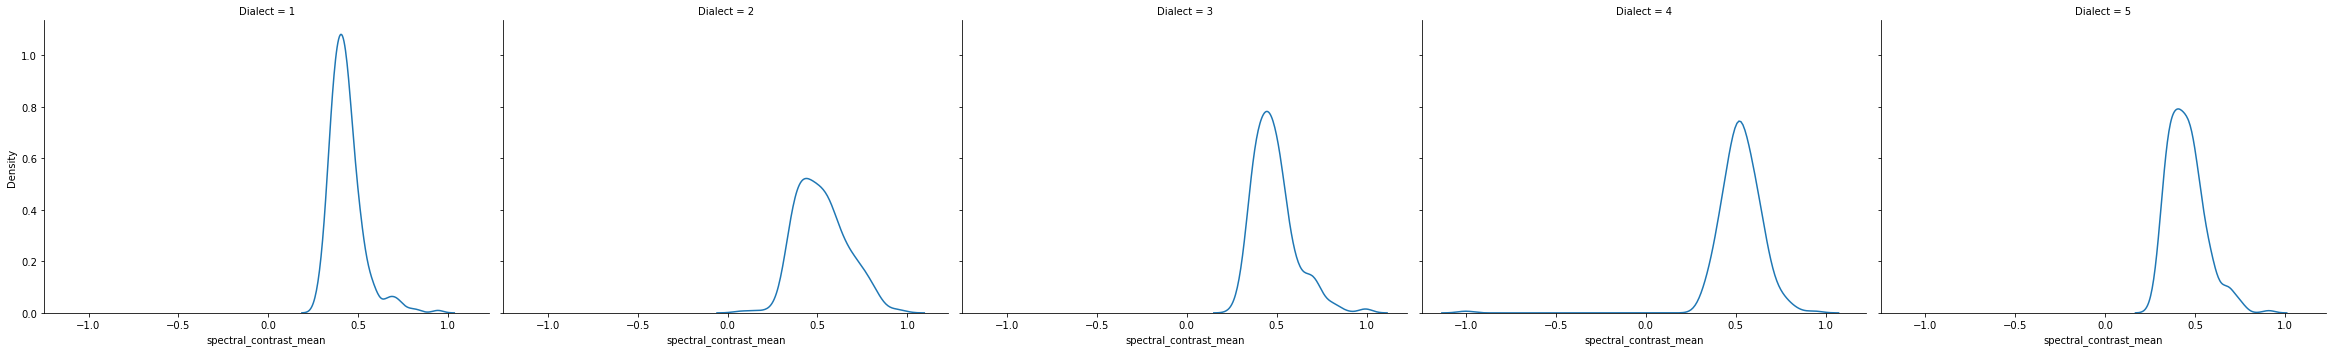

In [71]:
features = ["chroma_stft_mean", "spectral_rolloff_mean", "spectral_bandwidth_mean","spectral_centroid_mean","spectral_contrast_mean"]
for feature in features:
    sns.displot(
      data=data_cluster_2,
      x=feature,
      col="Dialect",
      kind="kde",
      aspect=1.3,
      bw_adjust=1
    )

In [3]:
# features = ["chroma_stft_mean", "spectral_rolloff_mean", "spectral_bandwidth_mean","spectral_centroid_mean","spectral_contrast_mean"]
features = ['mfcc1_mean', 'mfcc1_std','mfcc2_mean', 'mfcc2_std','mfcc3_mean', 'mfcc3_std','mfcc4_mean', 'mfcc4_std',
              'mfcc5_mean', 'mfcc5_std','mfcc6_mean', 'mfcc6_std','mfcc7_mean', 'mfcc7_std','mfcc8_mean', 'mfcc8_std',
              'mfcc9_mean', 'mfcc9_std','mfcc10_mean', 'mfcc10_std','mfcc11_mean', 'mfcc11_std','mfcc12_mean', 'mfcc12_std',
              'mfcc13_mean', 'mfcc13_std','zcr_mean', 'zcr_std', 'chroma_stft_mean', 'chroma_stft_std',
              'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_rolloff_mean', 'spectral_rolloff_std',
              'spectral_contrast_mean', 'spectral_contrast_std', 'spectral_bandwidth_mean', 'spectral_bandwidth_std']

Q:\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Q:\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Q:\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Q:\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Q:\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Q:\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Q:\anacond

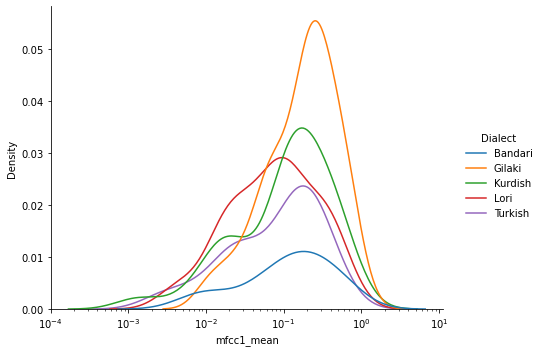

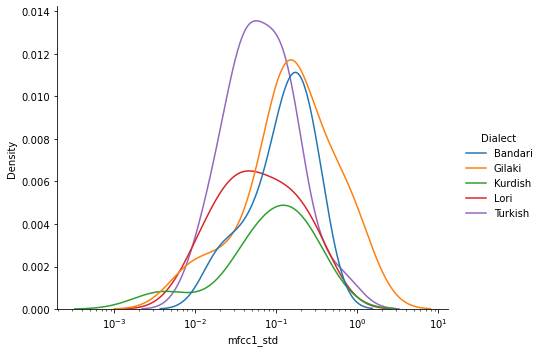

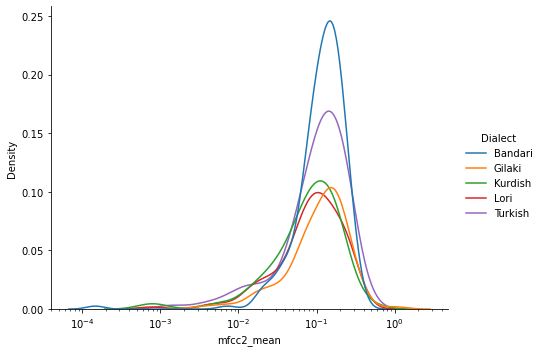

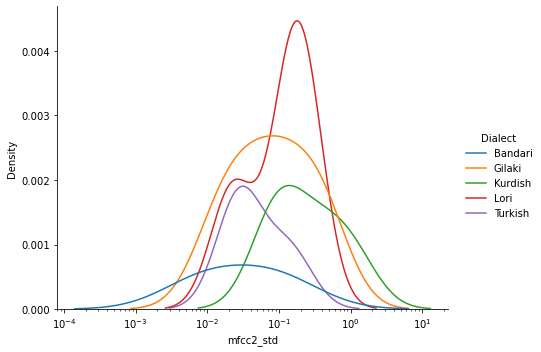

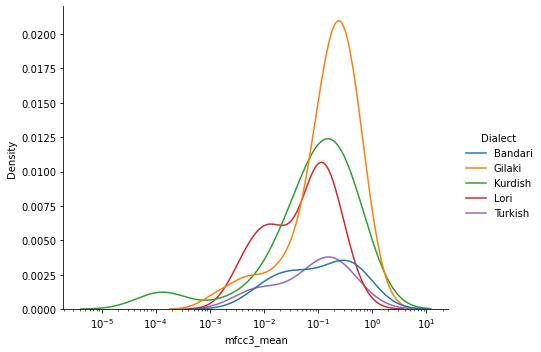

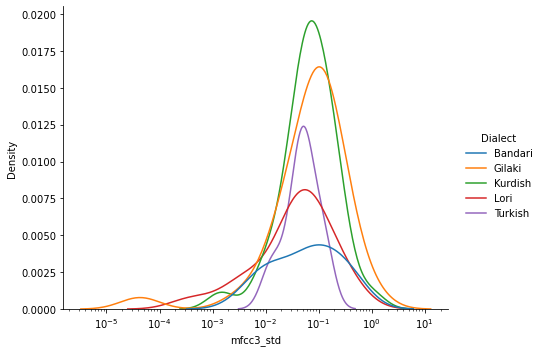

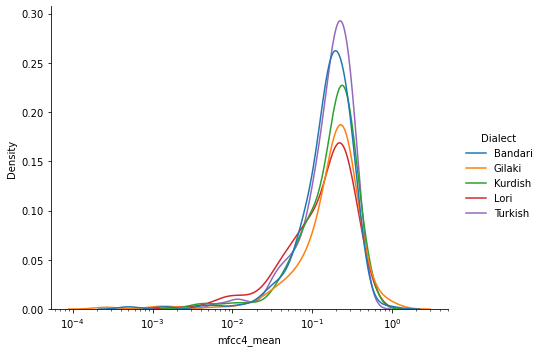

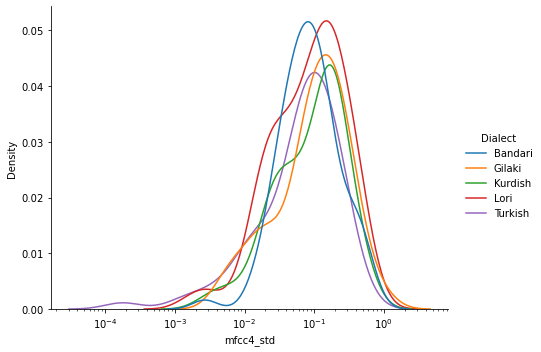

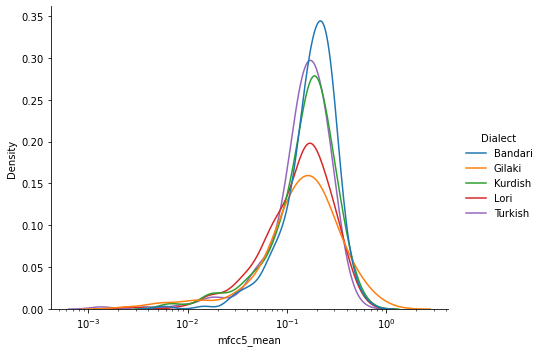

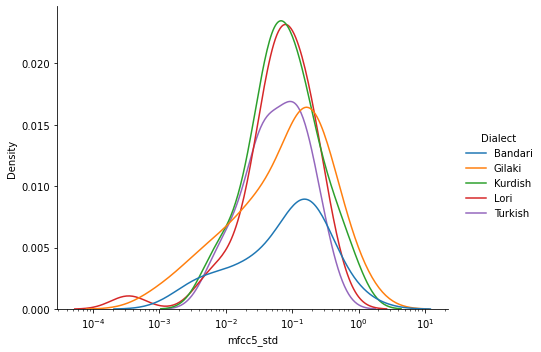

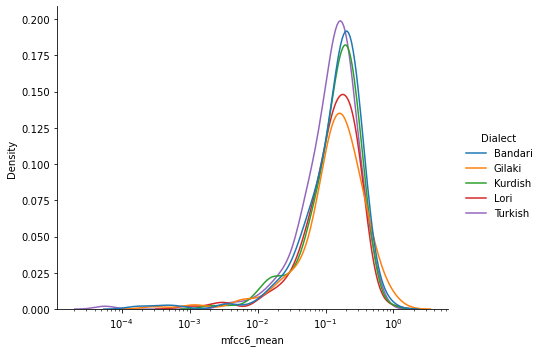

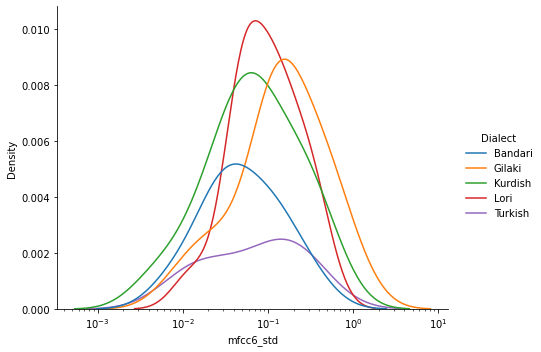

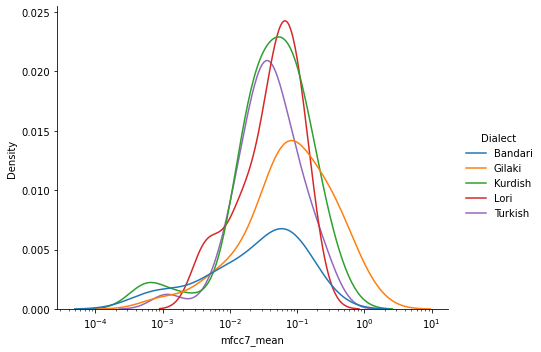

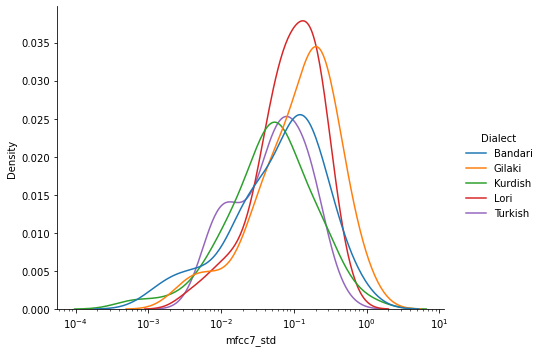

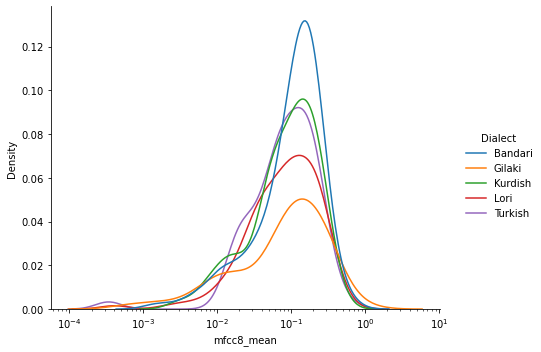

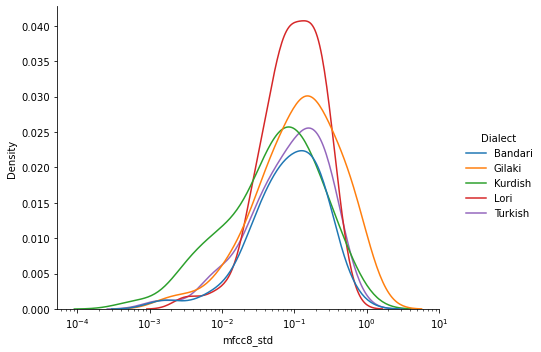

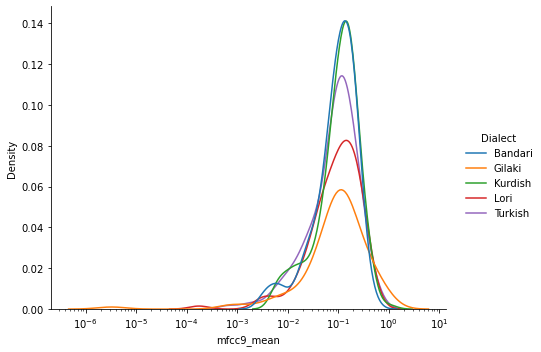

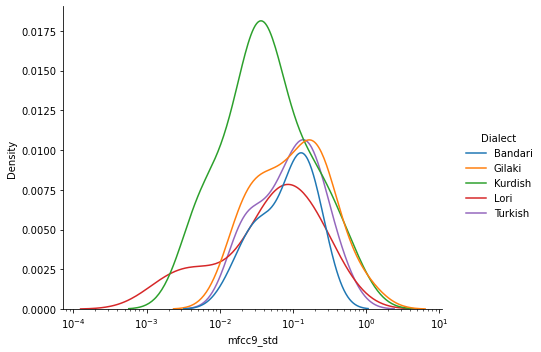

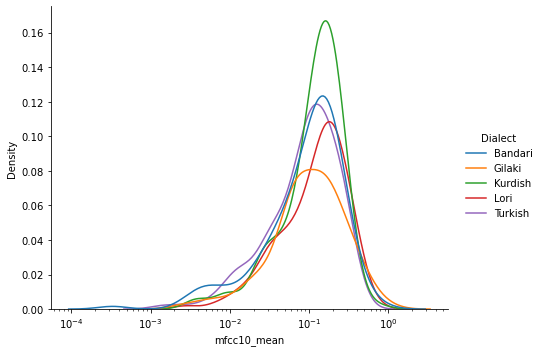

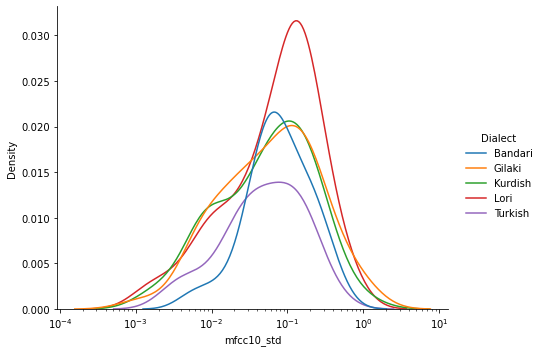

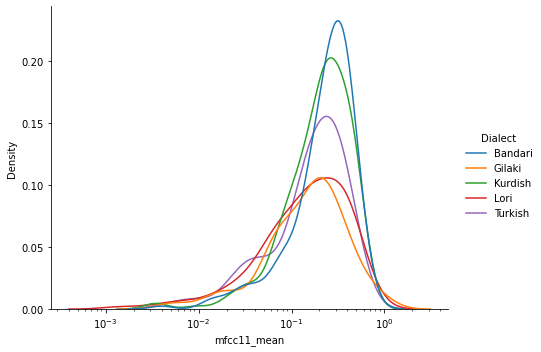

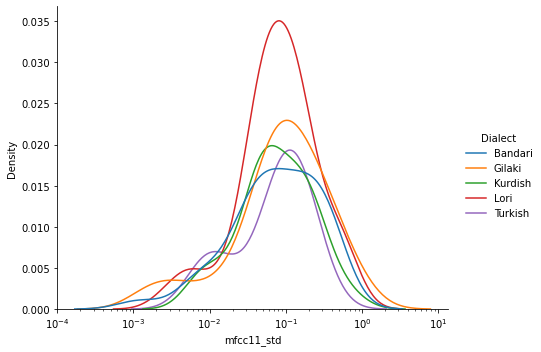

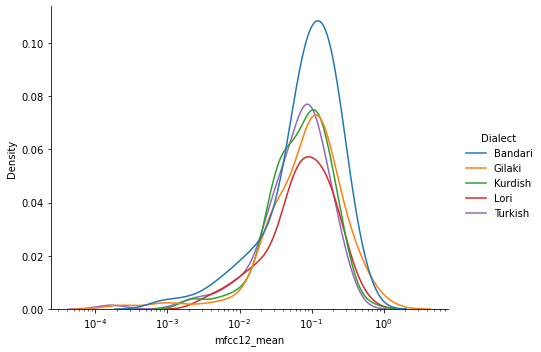

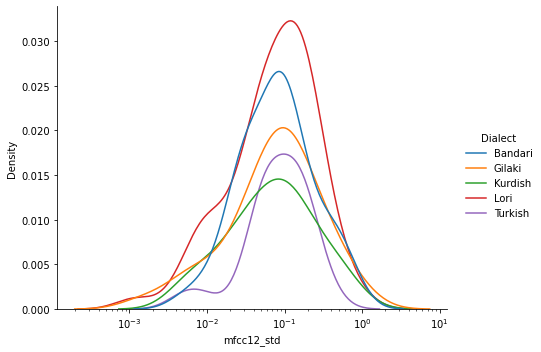

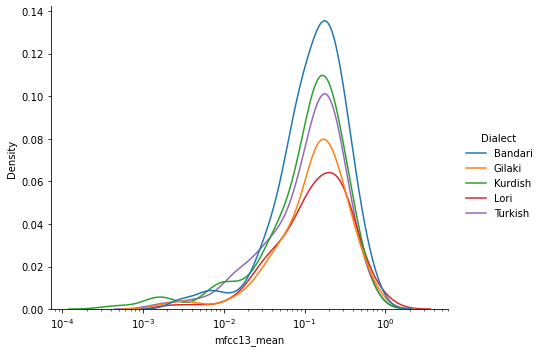

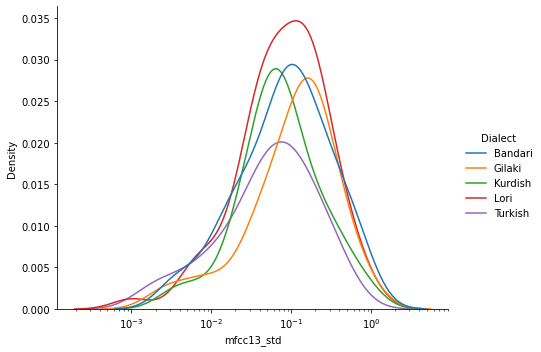

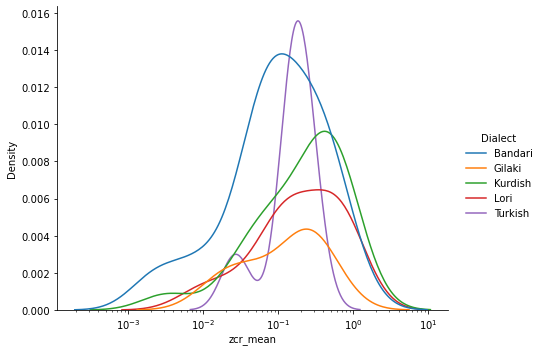

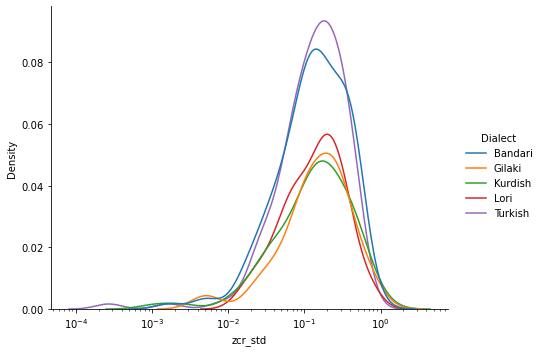

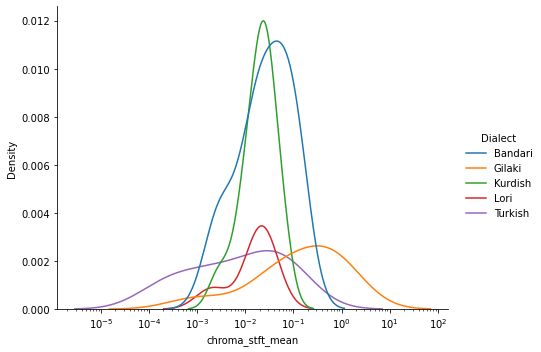

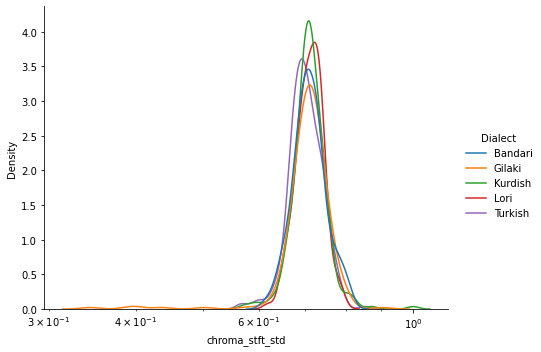

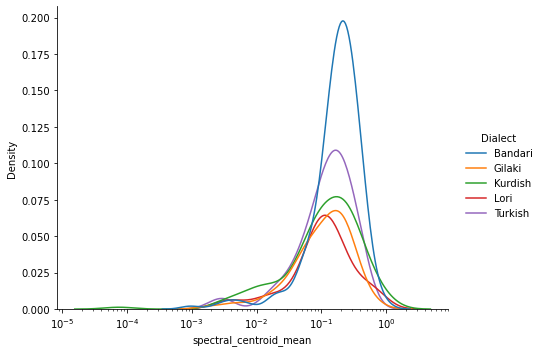

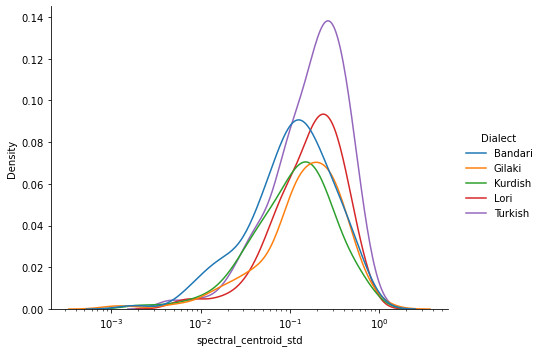

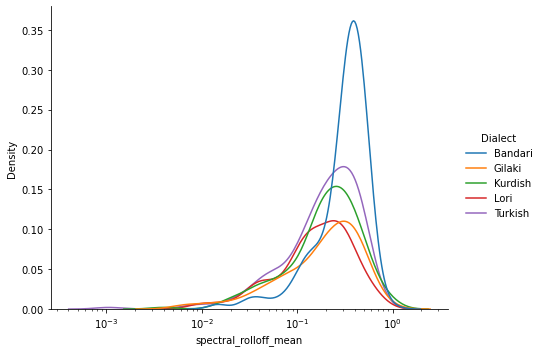

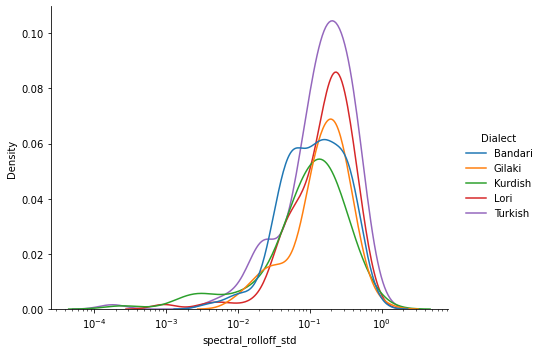

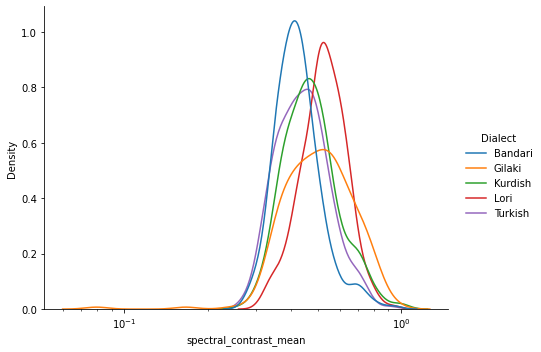

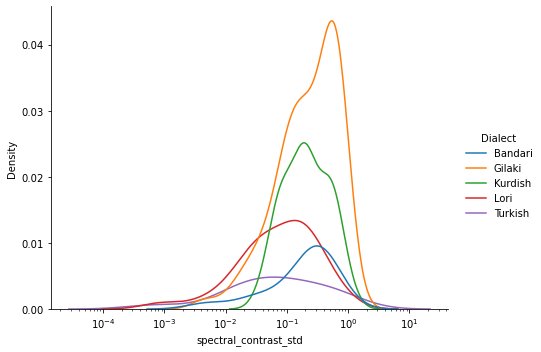

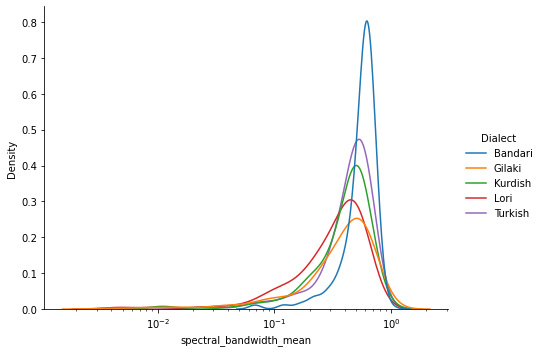

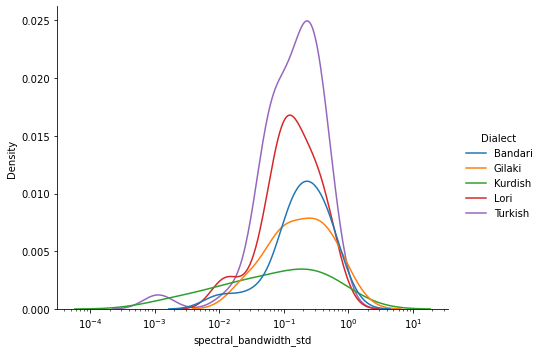

In [16]:
count = 0
for feature in features:
    count += 1
    sns.displot(
        data = data_cluster, 
        x=feature, 
        hue="Dialect", 
        kind="kde", 
        aspect=1.3, 
        log_scale=10)
    plt.savefig("dist_"+str(count))    

Q:\anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


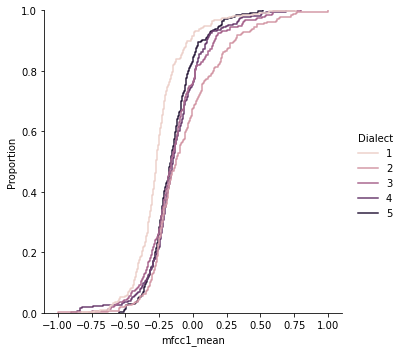

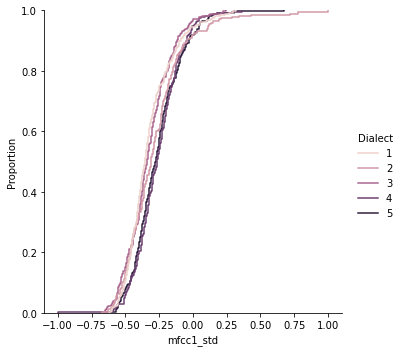

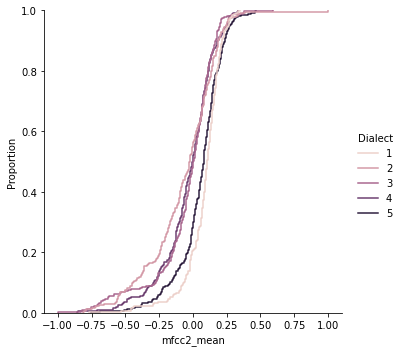

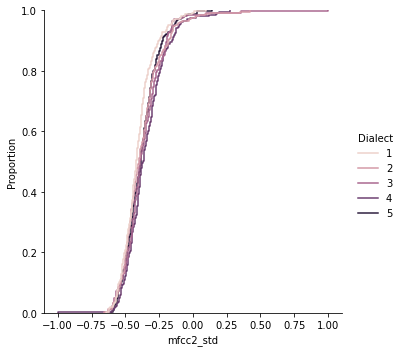

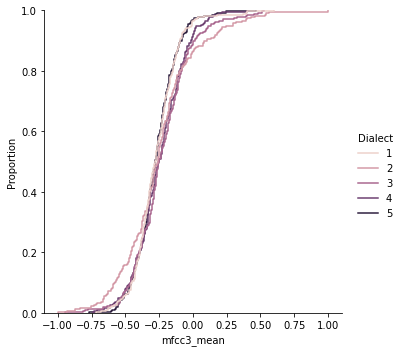

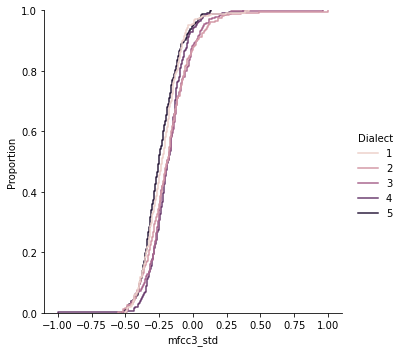

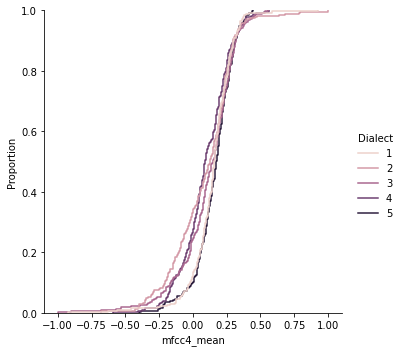

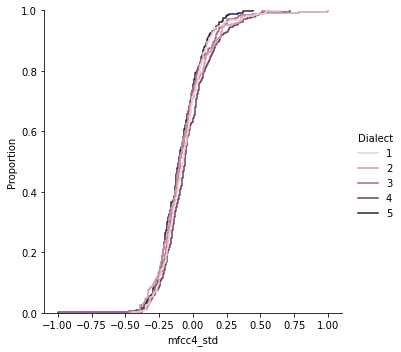

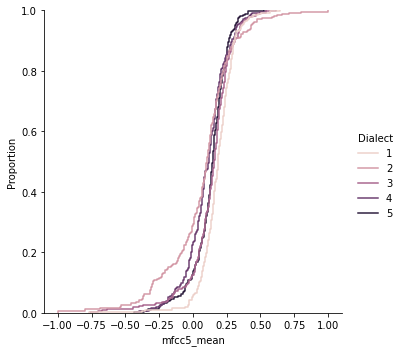

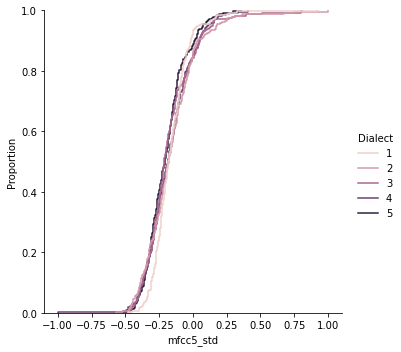

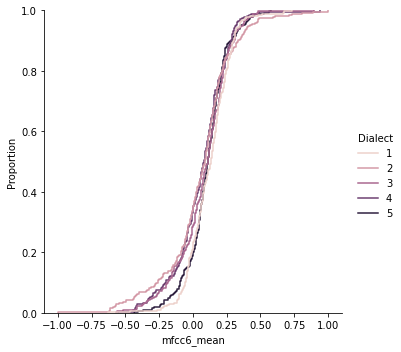

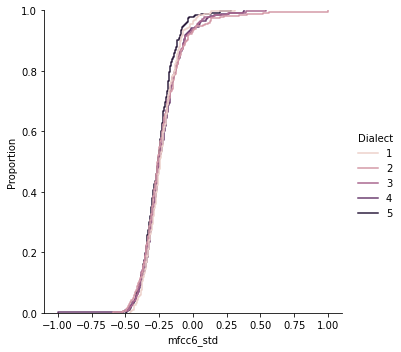

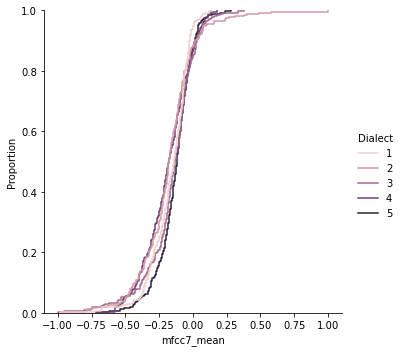

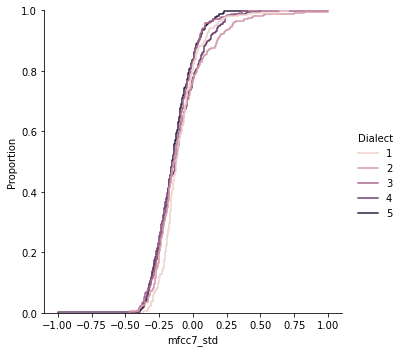

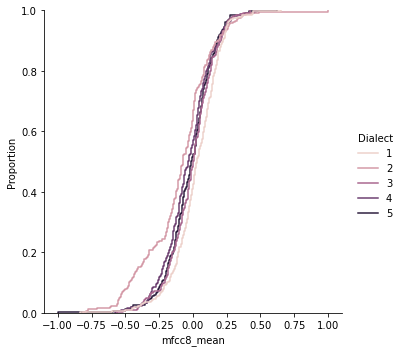

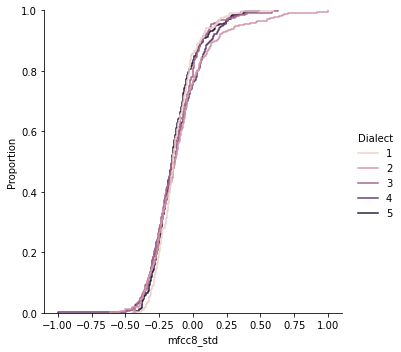

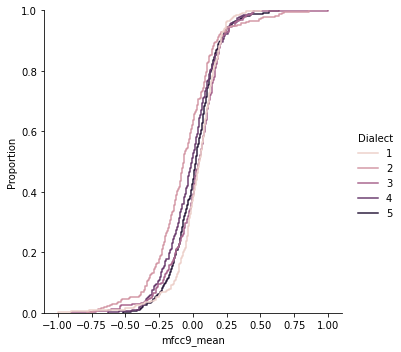

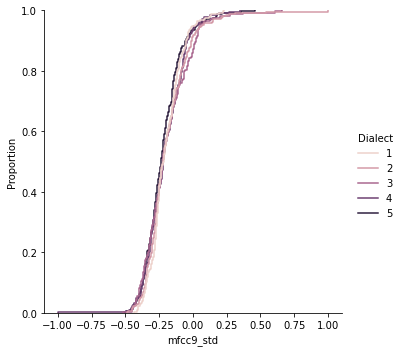

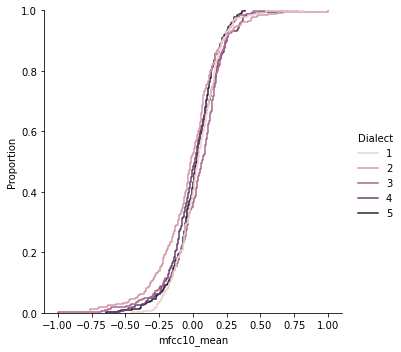

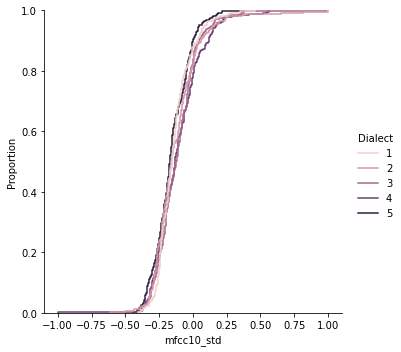

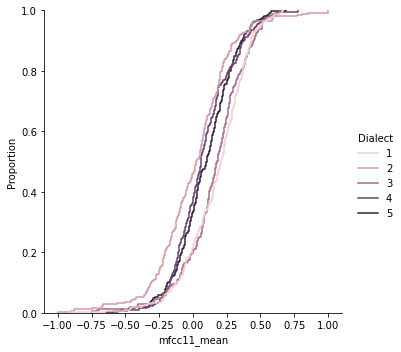

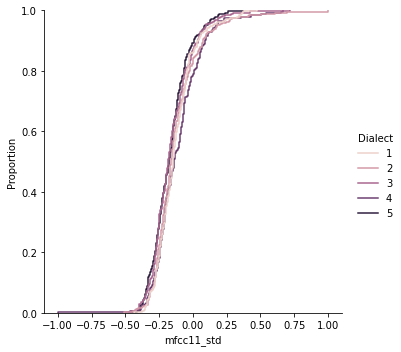

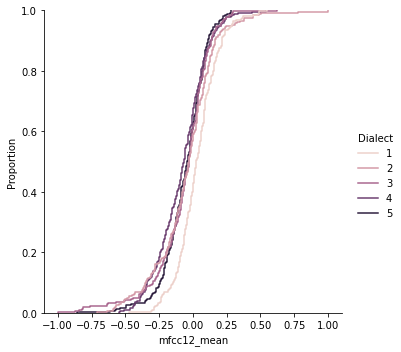

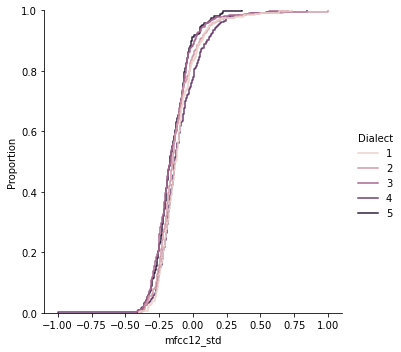

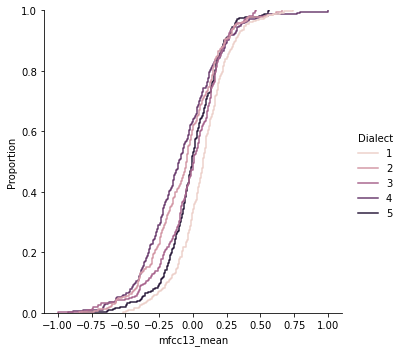

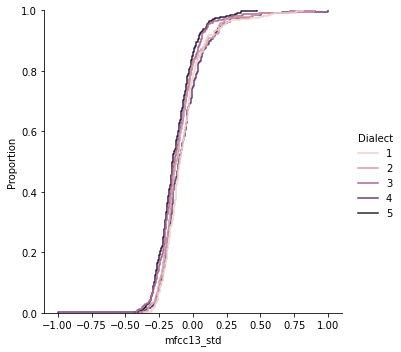

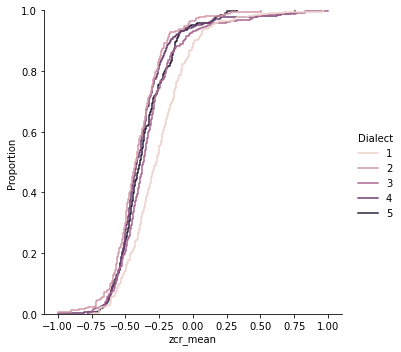

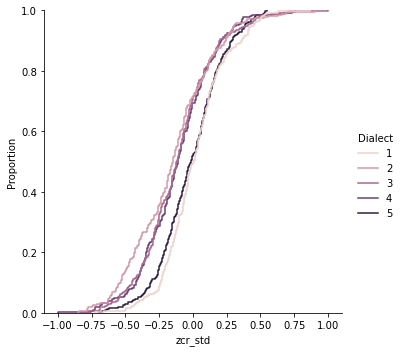

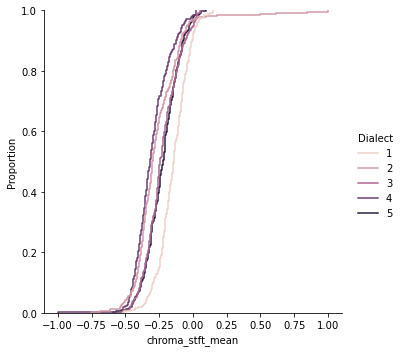

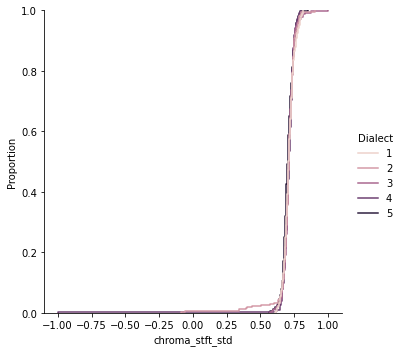

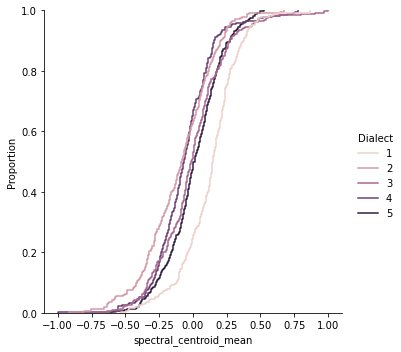

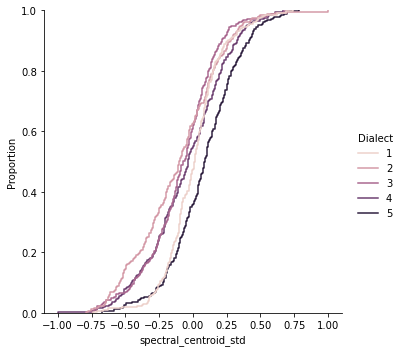

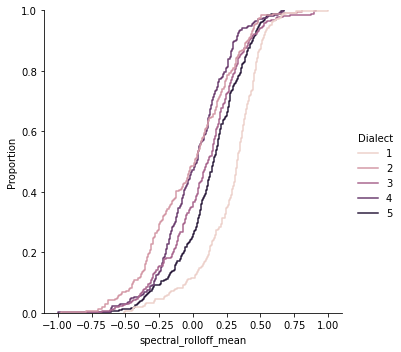

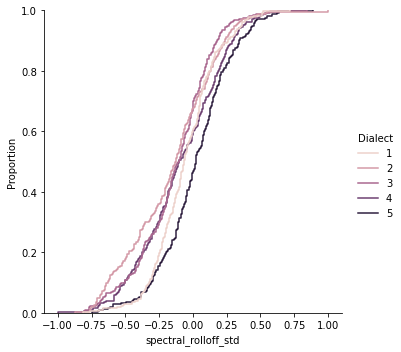

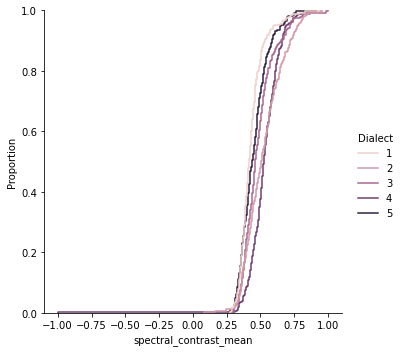

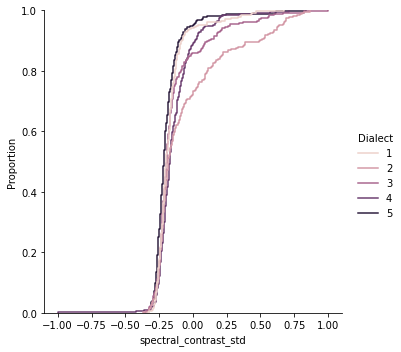

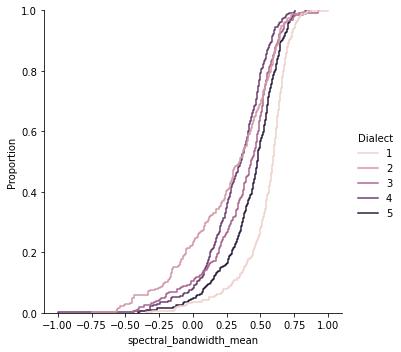

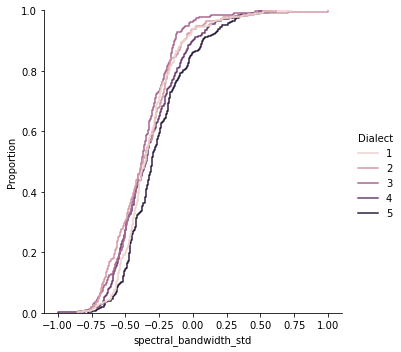

In [74]:
for feature in features:
    sns.displot(data_cluster, x=feature, hue="Dialect", kind="ecdf")

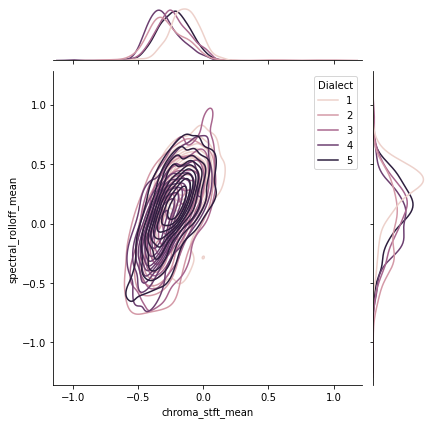

In [75]:
sns.jointplot(
    data=data_cluster,
    x="chroma_stft_mean", y="spectral_rolloff_mean", hue="Dialect",
    kind="kde"
)

## Comparing KMeans clustering with actual centroids, using LDA transform

In [153]:
n_components = 14
data = pandas.read_csv('music_dataset3.csv',index_col=False)
dataset = np.array(data)
lda = LinearDiscriminantAnalysis()
X = lda.fit_transform(dataset[:,:-1],dataset[:,-1])

data_pca_df = pandas.DataFrame(X)
data_pca_df = pd.concat([data_pca_df, data.iloc[:,-1]],axis=1)


genre_groupby = data_pca_df.groupby('Dialect').agg('mean')
clusters = genre_groupby.reset_index().rename({'Dialect':'cluster'}, axis=1)
clusters['method'] = 'Mean'

clusters

,cluster,0,1,2,3,method
0,Bandari,1.291532,-0.033012,0.194397,0.163417,Mean
1,Gilaki,-0.129392,0.900330,-0.287565,-0.110083,Mean
2,Kurdish,-0.456472,-0.095411,0.596970,-0.358421,Mean
3,Lori,-0.700030,-0.146658,0.029899,0.577509,Mean
4,Turkish,-0.017920,-0.578658,-0.533677,-0.250028,Mean


In [154]:
f = [0,1,2,3]
# X = clusters[f]

km = KMeans(n_clusters=5, n_init=5)
km.fit(X)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns=f)
km_clusters['cluster'] = ['Cluster {}'.format(l) for l in labels_unique]
km_clusters['method'] = 'KMeans'
cols = ['cluster'] + f + ['method']
clusters = pd.concat([clusters, km_clusters])
clusters = clusters[cols]
clusters

,cluster,0,1,2,3,method
0,Bandari,1.291532,-0.033012,0.194397,0.163417,Mean
1,Gilaki,-0.129392,0.900330,-0.287565,-0.110083,Mean
2,Kurdish,-0.456472,-0.095411,0.596970,-0.358421,Mean
3,Lori,-0.700030,-0.146658,0.029899,0.577509,Mean
4,Turkish,-0.017920,-0.578658,-0.533677,-0.250028,Mean
0,Cluster 0,-0.376371,-0.245435,-1.207982,0.739860,KMeans
1,Cluster 1,-0.517814,2.000364,-0.259228,-0.469757,KMeans
2,Cluster 2,1.463991,0.158799,0.460264,0.276070,KMeans
3,Cluster 3,0.141376,-0.724993,-0.138916,-0.739843,KMeans
4,Cluster 4,-1.244380,-0.202663,0.822297,0.338426,KMeans


Text(106.5, 0.5, 'KMeansLabel')

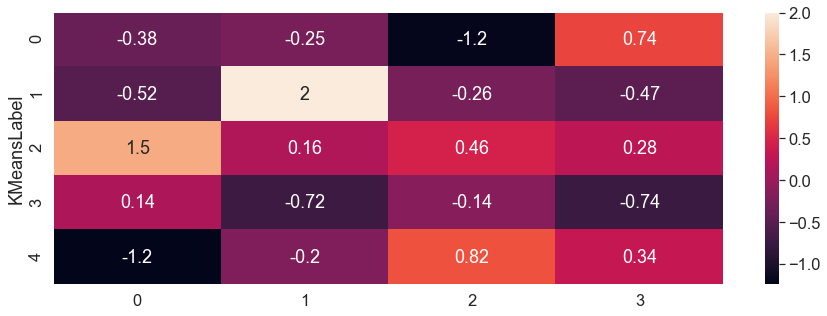

In [155]:
plt.figure(figsize=(15,5))
sns.set(font_scale=1.5)
sns.heatmap(
    data=clusters.loc[clusters.method=='KMeans', f],
    annot=True
)
plt.ylabel("KMeansLabel")

## Work with data, transformed by LDA

In [25]:
n_components = 14
data = pandas.read_csv('music_dataset3.csv',index_col=False)
dataset = np.array(data)
lda = LinearDiscriminantAnalysis()
X = lda.fit_transform(dataset[:,:-1],dataset[:,-1])
y = dataset[:,-1]

### Work with data, transformed by PCA

In [183]:
data = pandas.read_csv('music_dataset3.csv',index_col=False)
dataset = np.array(data)
n_components = 14
pca = PCA(n_components = n_components, whiten=True)
X = pca.fit_transform(dataset[:,:-1])
y = dataset[:,-1]

## Work with original data

In [181]:
data = pandas.read_csv('music_dataset3.csv',index_col=False)
dataset = np.array(data)
X = dataset[:,:-1]
y = dataset[:,-1]

## K-Means / PCA / LDA (You should choose from above cells)

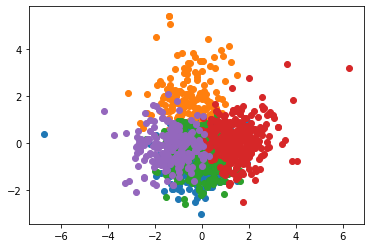

Adjusted Mutual Information score: 0.171
Normalized Mutual Information score: 0.174
Homogenity score: 0.171
Completeness score: 0.176
V-measure score: 0.174
Fowlkes-Malkows score: 0.326
Silhouette Score: 0.188
Calinski-Harabasz Index: 293.537
Davies-Bouldin Index is: 1.325

Contingency Matrix:

[[ 35   6  36 195   3]
 [ 56 101  45  42  22]
 [ 31  33 126  34  55]
 [ 95  15  34  22 103]
 [136   7  78  43  20]]


In [4]:
model = KMeans(init="random", n_clusters= 5, n_init=100)
y_pred = model.fit_predict(X)
clusters = unique(y_pred)

for cluster in clusters:
    row_ix = where(y_pred == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
plt.savefig("kmeans")    
plt.show()

print("Adjusted Mutual Information score: %.3f" %metrics.adjusted_mutual_info_score(dataset[:,-1], y_pred))
print("Normalized Mutual Information score: %.3f" %metrics.normalized_mutual_info_score(dataset[:,-1], y_pred))
print("Homogenity score: %.3f" %metrics.homogeneity_score(dataset[:,-1], y_pred))
print("Completeness score: %.3f" %metrics.completeness_score(dataset[:,-1], y_pred))
print("V-measure score: %.3f" %metrics.v_measure_score(dataset[:,-1],y_pred))
print("Fowlkes-Malkows score: %.3f" %metrics.fowlkes_mallows_score(dataset[:,-1], y_pred)) 
print("Silhouette Score: %.3f" %metrics.silhouette_score(X, y_pred, metric='euclidean'))   
print("Calinski-Harabasz Index: %.3f" %metrics.calinski_harabasz_score(X, y_pred))
print("Davies-Bouldin Index is: %.3f" %metrics.davies_bouldin_score(X, y_pred))
print("\nContingency Matrix:\n")
print(metrics.cluster.contingency_matrix(dataset[:,-1], y_pred))

## Hierarchical Clustering / PCA / LDA

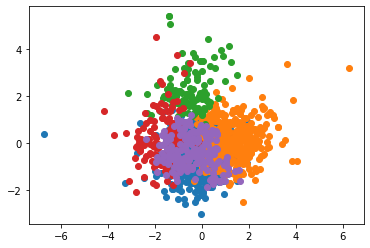

Adjusted Mutual Information score: 0.166
Normalized Mutual Information score: 0.170
Homogenity score: 0.161
Completeness score: 0.179
V-measure score: 0.170
Fowlkes-Malkows score: 0.336
Silhouette Score: 0.147
Calinski-Harabasz Index: 241.583
Davies-Bouldin Index is: 1.451

Contingency Matrix:

[[ 46 208   2   2  17]
 [ 96  44  76  21  29]
 [ 69  61  22  27 100]
 [136  27   7  77  22]
 [185  36   4  11  48]]


In [5]:
model = AgglomerativeClustering(n_clusters=5)
y_pred = model.fit_predict(X)
clusters = unique(y_pred)

for cluster in clusters:
    row_ix = where(y_pred == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

plt.savefig("hierlda")    
plt.show()

print("Adjusted Mutual Information score: %.3f" %metrics.adjusted_mutual_info_score(dataset[:,-1], y_pred))
print("Normalized Mutual Information score: %.3f" %metrics.normalized_mutual_info_score(dataset[:,-1], y_pred))
print("Homogenity score: %.3f" %metrics.homogeneity_score(dataset[:,-1], y_pred))
print("Completeness score: %.3f" %metrics.completeness_score(dataset[:,-1], y_pred))
print("V-measure score: %.3f" %metrics.v_measure_score(dataset[:,-1],y_pred))
print("Fowlkes-Malkows score: %.3f" %metrics.fowlkes_mallows_score(dataset[:,-1], y_pred)) 
print("Silhouette Score: %.3f" %metrics.silhouette_score(X, y_pred, metric='euclidean'))   
print("Calinski-Harabasz Index: %.3f" %metrics.calinski_harabasz_score(X, y_pred))
print("Davies-Bouldin Index is: %.3f" %metrics.davies_bouldin_score(X, y_pred))
print("\nContingency Matrix:\n")
print(metrics.cluster.contingency_matrix(dataset[:,-1], y_pred))

## Dendrogram

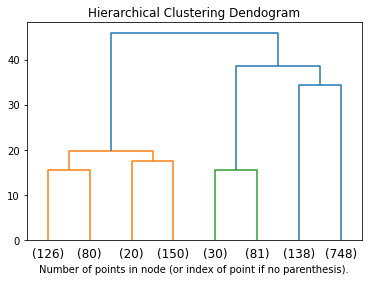

In [6]:
def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X)

plot_dendrogram(model, truncate_mode='level', p=2)

plt.title('Hierarchical Clustering Dendogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## DBSCAN / PCA / LDA

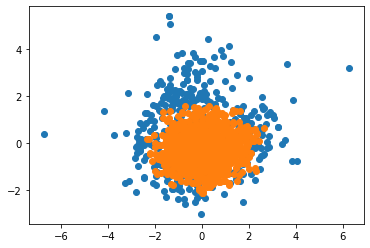

Adjusted Mutual Information score: 0.011
Normalized Mutual Information score: 0.012
Homogenity score: 0.008
Completeness score: 0.022
V-measure score: 0.012
Fowlkes-Malkows score: 0.349
Silhouette Score: 0.223
Calinski-Harabasz Index: 58.207
Davies-Bouldin Index is: 4.597

Contingency Matrix:

[[ 82 193]
 [103 163]
 [ 74 205]
 [ 87 182]
 [ 48 236]]


In [20]:
model = DBSCAN(eps= 1, min_samples= 50)
y_pred = model.fit_predict(X)
clusters = unique(y_pred)

for cluster in clusters:
    row_ix = where(y_pred == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
    
plt.show()

print("Adjusted Mutual Information score: %.3f" %metrics.adjusted_mutual_info_score(dataset[:,-1], y_pred))
print("Normalized Mutual Information score: %.3f" %metrics.normalized_mutual_info_score(dataset[:,-1], y_pred))
print("Homogenity score: %.3f" %metrics.homogeneity_score(dataset[:,-1], y_pred))
print("Completeness score: %.3f" %metrics.completeness_score(dataset[:,-1], y_pred))
print("V-measure score: %.3f" %metrics.v_measure_score(dataset[:,-1],y_pred))
print("Fowlkes-Malkows score: %.3f" %metrics.fowlkes_mallows_score(dataset[:,-1], y_pred)) 
print("Silhouette Score: %.3f" %metrics.silhouette_score(X, y_pred, metric='euclidean'))   
print("Calinski-Harabasz Index: %.3f" %metrics.calinski_harabasz_score(X, y_pred))
print("Davies-Bouldin Index is: %.3f" %metrics.davies_bouldin_score(X, y_pred))
print("\nContingency Matrix:\n")
print(metrics.cluster.contingency_matrix(dataset[:,-1], y_pred))

## Gaussian Mixture / PCA / LDA

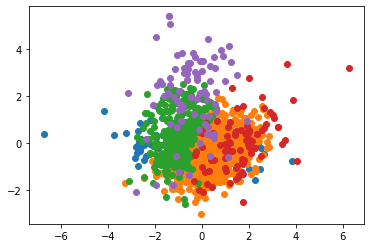

Adjusted Mutual Information score: 0.106
Normalized Mutual Information score: 0.110
Homogenity score: 0.095
Completeness score: 0.131
V-measure score: 0.110
Fowlkes-Malkows score: 0.327
Silhouette Score: 0.135
Calinski-Harabasz Index: 125.765
Davies-Bouldin Index is: 2.109

Contingency Matrix:

[[ 14 188   9  59   5]
 [  6 123  88   4  45]
 [  9 123 120  10  17]
 [ 39 114  89  12  15]
 [  8 240  27   5   4]]


In [21]:
model = GaussianMixture(n_components=5)
y_pred = model.fit_predict(X)
clusters = unique(y_pred)

for cluster in clusters:
    row_ix = where(y_pred == cluster)
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
plt.savefig("gaussmixlda")    
plt.show()

print("Adjusted Mutual Information score: %.3f" %metrics.adjusted_mutual_info_score(dataset[:,-1], y_pred))
print("Normalized Mutual Information score: %.3f" %metrics.normalized_mutual_info_score(dataset[:,-1], y_pred))
print("Homogenity score: %.3f" %metrics.homogeneity_score(dataset[:,-1], y_pred))
print("Completeness score: %.3f" %metrics.completeness_score(dataset[:,-1], y_pred))
print("V-measure score: %.3f" %metrics.v_measure_score(dataset[:,-1],y_pred))
print("Fowlkes-Malkows score: %.3f" %metrics.fowlkes_mallows_score(dataset[:,-1], y_pred)) 
print("Silhouette Score: %.3f" %metrics.silhouette_score(X, y_pred, metric='euclidean'))   
print("Calinski-Harabasz Index: %.3f" %metrics.calinski_harabasz_score(X, y_pred))
print("Davies-Bouldin Index is: %.3f" %metrics.davies_bouldin_score(X, y_pred))
print("\nContingency Matrix:\n")
print(metrics.cluster.contingency_matrix(dataset[:,-1], y_pred))

## Clustering with different number of clusters

In [22]:
from time import time

def clustering_fit_stats(estimator, name, data):
    
    t0 = time()
    y_pred = estimator.fit_predict(data)
    
    print('%-9s\t%.3fs\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f  %.3f'
          % (name, (time() - t0),
             metrics.adjusted_rand_score(y, y_pred),
             metrics.adjusted_mutual_info_score(y, y_pred),
             metrics.normalized_mutual_info_score(y, y_pred),
             metrics.homogeneity_score(y, y_pred),
             metrics.completeness_score(y, y_pred),
             metrics.v_measure_score(y,y_pred),
             metrics.silhouette_score(X, y_pred, metric='euclidean'),
             metrics.calinski_harabasz_score(X, y_pred),
             metrics.davies_bouldin_score(X, y_pred)))
    
def clustering_plot(estimator, data, figname):

    # fit model and predict clusters
    y_pred = estimator.fit_predict(data)

    # retrieve unique clusters
    clusters = np.unique(y_pred)

    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(y_pred == cluster)
        # create scatter of these samples
        plt.scatter(data[row_ix, 0], data[row_ix, 1])
    plt.savefig(figname)
    plt.show()



type		time	R-Score	AMI	NMI	Homo	Comp	V-meas	Silh	CH-score  DB-score
____________________________________________________________________________________________________
hierarchical 6	0.091s	0.136	0.166	0.170	0.161	0.179	0.170	0.147	241.583  1.451
hierarchical 5	0.098s	0.136	0.166	0.170	0.161	0.179	0.170	0.147	241.583  1.451
hierarchical 4	0.079s	0.136	0.166	0.170	0.161	0.179	0.170	0.147	241.583  1.451
hierarchical 3	0.070s	0.136	0.166	0.170	0.161	0.179	0.170	0.147	241.583  1.451
hierarchical 2	0.076s	0.136	0.166	0.170	0.161	0.179	0.170	0.147	241.583  1.451


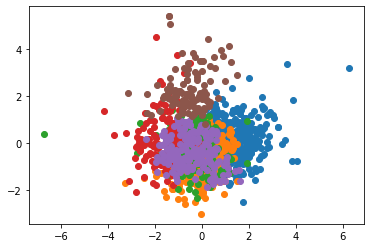

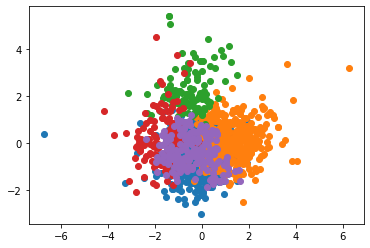

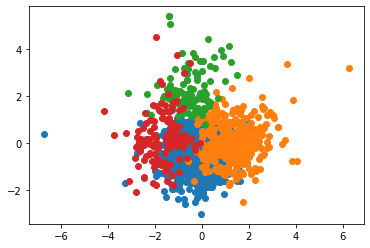

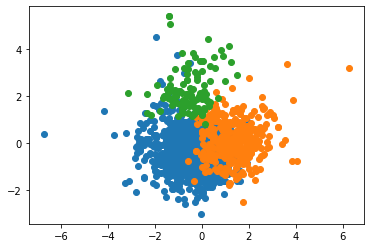

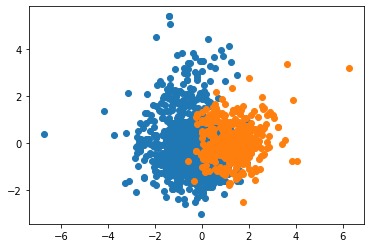

In [23]:
print('\n')
print('type\t\ttime\tR-Score\tAMI\tNMI\tHomo\tComp\tV-meas\tSilh\tCH-score  DB-score')
print(100 * '_')

# clustering_fit_stats(KMeans(n_clusters= 6, random_state= 6), name="K-means 6", data= X)
# clustering_fit_stats(KMeans(n_clusters= 5, random_state= 6), name="K-means 5", data= X)
# clustering_fit_stats(KMeans(n_clusters= 4, random_state= 6), name="K-means 4", data= X)
# clustering_fit_stats(KMeans(n_clusters= 3, random_state= 6), name="K-means 3", data= X)
# clustering_fit_stats(KMeans(n_clusters= 2, random_state= 6), name="K-means 2", data= X)

clustering_fit_stats(AgglomerativeClustering(n_clusters=5), name="hierarchical 6", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters=5), name="hierarchical 5", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters=5), name="hierarchical 4", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters=5), name="hierarchical 3", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters=5), name="hierarchical 2", data= X)

# clustering_fit_stats(GaussianMixture(n_components=5), name="GaussianMixture 6", data= X)
# clustering_fit_stats(GaussianMixture(n_components=5), name="GaussianMixture 5", data= X)
# clustering_fit_stats(GaussianMixture(n_components=5), name="GaussianMixture 4", data= X)
# clustering_fit_stats(GaussianMixture(n_components=5), name="GaussianMixture 3", data= X)
# clustering_fit_stats(GaussianMixture(n_components=5), name="GaussianMixture 2", data= X)

clustering_plot(AgglomerativeClustering(n_clusters= 6), X, "cluster6")
clustering_plot(AgglomerativeClustering(n_clusters= 5), X, "cluster5")
clustering_plot(AgglomerativeClustering(n_clusters= 4), X, "cluster4")
clustering_plot(AgglomerativeClustering(n_clusters= 3), X, "cluster3")
clustering_plot(AgglomerativeClustering(n_clusters= 2), X, "cluster2")

## Clustering with different algorithms (Summary) 



type		time	R-Score	AMI	NMI	Homo	Comp	V-meas	Silh	CH-score  DB-score
____________________________________________________________________________________________________
K-means  	0.181s	0.157	0.176	0.179	0.178	0.181	0.179	0.187	293.504  1.328
Agglomerative	0.100s	0.136	0.166	0.170	0.161	0.179	0.170	0.147	241.583  1.451
GMM      	0.081s	0.049	0.114	0.117	0.100	0.142	0.117	0.117	144.803  1.666


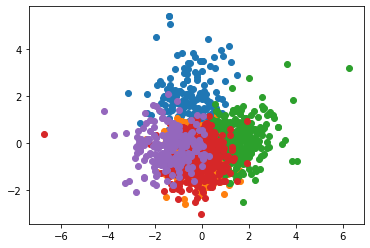

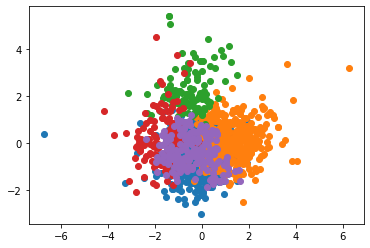

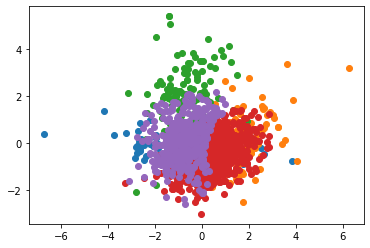

In [24]:
print('\n')
print('type\t\ttime\tR-Score\tAMI\tNMI\tHomo\tComp\tV-meas\tSilh\tCH-score  DB-score')
print(100 * '_')

clustering_fit_stats(KMeans(n_clusters= 5), name="K-means", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters=5) , name="Agglomerative", data= X)
# clustering_fit_stats(DBSCAN(eps= 2, min_samples= 10), name="DBSCAN", data= X)
clustering_fit_stats(GaussianMixture(n_components= 5), name="GMM", data= X)
                     
clustering_plot(KMeans(n_clusters= 5), X, "kmeans")
clustering_plot(AgglomerativeClustering(n_clusters=5), X, "agg")
# clustering_plot(DBSCAN(eps= 2, min_samples= 10), X)
clustering_plot(GaussianMixture(n_components= 5), X, "gauss")

## Clustering with different algorithms, using a smaller dataset



type		time	R-Score	AMI	NMI	Homo	Comp	V-meas	Silh	CH-score  DB-score
____________________________________________________________________________________________________
K-means  	0.038s	0.836	0.836	0.848	0.847	0.848	0.848	0.361	47.997  0.946
Agglomerative	0.001s	0.597	0.679	0.704	0.693	0.715	0.704	0.291	39.689  1.091
GMM      	0.031s	0.614	0.692	0.715	0.712	0.719	0.715	0.237	31.719  1.289


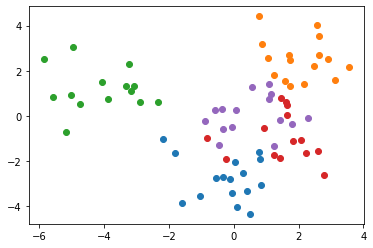

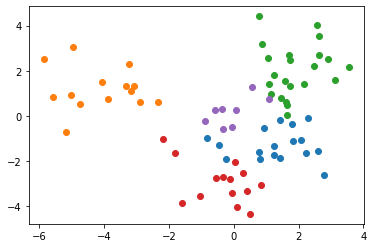

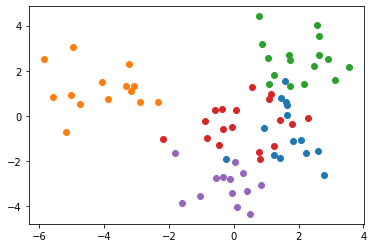

In [26]:
print('\n')
print('type\t\ttime\tR-Score\tAMI\tNMI\tHomo\tComp\tV-meas\tSilh\tCH-score  DB-score')
print(100 * '_')

clustering_fit_stats(KMeans(n_clusters= 5), name="K-means", data= X)
clustering_fit_stats(AgglomerativeClustering(n_clusters=5) , name="Agglomerative", data= X)
# clustering_fit_stats(DBSCAN(eps= 2, min_samples= 10), name="DBSCAN", data= X)
clustering_fit_stats(GaussianMixture(n_components= 5), name="GMM", data= X)
                     
clustering_plot(KMeans(n_clusters= 5), X, "kmeans")
clustering_plot(AgglomerativeClustering(n_clusters=5), X, "agg")
# clustering_plot(DBSCAN(eps= 2, min_samples= 10), X)
clustering_plot(GaussianMixture(n_components= 5), X, "gauss")